In [49]:
import os
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from tqdm.auto import tqdm
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt


In [50]:
class FootprintPatchDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = []

        for class_idx, class_name in enumerate(sorted(os.listdir(self.root_dir))):
            class_path = self.root_dir / class_name
            if not class_path.is_dir():
                continue

            self.class_to_idx[class_name] = class_idx
            self.idx_to_class.append(class_name)

            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.image_paths.append(class_path / fname)
                    self.labels.append(class_idx)

        print(f"Loaded {len(self.image_paths)} images "
              f"from {self.root_dir}, {len(self.idx_to_class)} classes.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [51]:
class FootprintEncoder(nn.Module):
    def __init__(self, feature_dim=256):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(256, feature_dim)
        self.out_dim = feature_dim

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class BackboneEncoder(nn.Module):
    """
    Wrap torchvision backbones to output a feature vector h.
    Supports: resnet50, vgg16, vit_b_16
    """
    def __init__(self, name="resnet50", pretrained=True):
        super().__init__()
        self.name = name

        if name == "resnet50":
            m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            self.backbone = nn.Sequential(*list(m.children())[:-1])  # remove fc
            self.out_dim = 2048

        elif name == "vgg16":
            m = models.vgg16(weights=models.VGG16_Weights.DEFAULT if pretrained else None)
            self.backbone = m.features
            self.pool = nn.AdaptiveAvgPool2d((7, 7))
            # VGG classifier input is 512*7*7
            self.out_dim = 512 * 7 * 7

        elif name == "vit_b_16":
            m = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT if pretrained else None)
            # remove classification head
            m.heads = nn.Identity()
            self.backbone = m
            self.out_dim = 768

        else:
            raise ValueError(f"Unknown backbone name: {name}")

    def forward(self, x):
        if self.name == "resnet50":
            h = self.backbone(x)           # (B, 2048, 1, 1)
            h = h.flatten(1)               # (B, 2048)
            return h

        elif self.name == "vgg16":
            h = self.backbone(x)           # (B, 512, H, W)
            h = self.pool(h)               # (B, 512, 7, 7)
            h = h.flatten(1)               # (B, 25088)
            return h

        elif self.name == "vit_b_16":
            h = self.backbone(x)           # (B, 768)
            return h

# Projector & Text encoder

class ImageProjector(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

class TextTokenEncoder(nn.Module):
    """
    Simple text token encoder using an embedding layer.
    take class ID as text token input , no species name
    """
    def __init__(self, num_classes, out_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, out_dim)

    def forward(self, labels):
        return self.embedding(labels)

In [52]:
PATCH_ROOT = Path("/users/PAS2985/tingle9/dataset/footprint_patches")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def get_eval_transform(backbone: str):
    """
      - cnn: 128, ToTensor
      - resnet/vgg: 128, ToTensor + normalize
      - vit: 224, ToTensor + normalize
    """
    
    if backbone == "cnn":
        img_size = 128
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
    else:
        if backbone == "vit_b_16":
            img_size = 224
        else:
            img_size = 128

        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])

def build_loaders(backbone: str, batch_size=64, num_workers=4):
    tfm = get_eval_transform(backbone)

    train_ds = FootprintPatchDataset(PATCH_ROOT / "train", transform=tfm)
    test_ds  = FootprintPatchDataset(PATCH_ROOT / "test",  transform=tfm)

    num_classes = len(train_ds.idx_to_class)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_ds, test_ds, train_loader, test_loader, num_classes

def load_contrastive_encoder_for_eval(backbone: str, device):
    """
    contrastive pretrain encoder load
    
    """
    if backbone == "cnn":
        ckpt_path = "footprint_encoder_contrastive.pth"
        enc = FootprintEncoder(feature_dim=256).to(device)
    else:
        ckpt_path = f"encoder_{backbone}_contrastive.pth"
        enc = BackboneEncoder(name=backbone, pretrained=False).to(device)

    state = torch.load(ckpt_path, map_location=device)
    enc.load_state_dict(state)
    enc.eval()
    for p in enc.parameters():
        p.requires_grad = False
    print(f"loaded [{backbone}] contrastive encoder.")
    return enc

def load_alignment_heads(backbone: str, num_classes: int, encoder_out_dim: int, proj_dim=128, device=DEVICE):
    """
    text alignment(RQ2) projector & token encoder load
    
    """
    if backbone == "cnn":
        proj_path = "rq2_CNN_image_projector.pth"
        txt_path  = "rq2_CNN_text_token_encoder.pth"
    else:
        proj_path = f"rq2_{backbone}_image_projector.pth"
        txt_path  = f"rq2_{backbone}_text_token_encoder.pth"

    img_proj = ImageProjector(encoder_out_dim, proj_dim).to(device)
    txt_enc  = TextTokenEncoder(num_classes, proj_dim).to(device)

    img_proj.load_state_dict(torch.load(proj_path, map_location=device))
    txt_enc.load_state_dict(torch.load(txt_path,  map_location=device))

    img_proj.eval()
    txt_enc.eval()
    print(f"loaded [{backbone}] alignment heads")
    return img_proj, txt_enc

In [53]:
def collect_projected_image_embeddings(encoder, img_proj, loader, device,
                                       class_subset=None, max_per_class=50):
    encoder.eval()
    img_proj.eval()
    feats = []
    labels = []
    used_per_class = {}

    with torch.no_grad():
        for images, y in tqdm(loader, desc="TSNE-Encode", leave=False):
            images = images.to(device)
            y = y.to(device)

            # subset
            if class_subset is not None:
                mask = torch.zeros_like(y, dtype=torch.bool)
                for c in class_subset:
                    mask = mask | (y == c)
                if mask.sum() == 0:
                    continue
                images = images[mask]
                y = y[mask]

            keep_idx = []
            for i, label in enumerate(y.tolist()):
                if class_subset is not None and label not in class_subset:
                    continue
                cnt = used_per_class.get(label, 0)
                if cnt < max_per_class:
                    used_per_class[label] = cnt + 1
                    keep_idx.append(i)

            if len(keep_idx) == 0:
                continue

            images = images[keep_idx]
            y = y[keep_idx]

            h = encoder(images)           # (B, D)
            z = img_proj(h)               # (B, 128)
            z = F.normalize(z, dim=1)

            feats.append(z.cpu())
            labels.append(y.cpu())

    if len(feats) == 0:
        return None, None

    feats = torch.cat(feats, 0)   # (N, 128)
    labels = torch.cat(labels, 0) # (N,)
    return feats, labels


def collect_text_embeddings(txt_enc, class_subset, device):
    """
    collect text token embedding for subset.
    """
    txt_enc.eval()
    with torch.no_grad():
        class_ids = torch.tensor(class_subset, device=device)
        z_txt = txt_enc(class_ids)   # (C_subset, 128)
        z_txt = F.normalize(z_txt, dim=1)
    return z_txt.cpu(), class_ids.cpu()


def plot_tsne(image_z, image_labels, text_z, text_labels, idx_to_class, title):
    """
    image_z: (Ni, d)
    image_labels: (Ni,)
    text_z: (Nt, d)
    text_labels: (Nt,)
    """
    
    all_z = torch.cat([image_z, text_z], dim=0).numpy()
    n_img = image_z.size(0)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        init="pca",
        random_state=42
    )
    z_2d = tsne.fit_transform(all_z)

    img_2d = z_2d[:n_img]
    txt_2d = z_2d[n_img:]

    img_labels = image_labels.numpy()
    txt_labels = text_labels.numpy()

    plt.figure(figsize=(8, 6))
    
    classes = sorted(list(set(img_labels.tolist())))
    cmap = plt.get_cmap("tab10")
    color_map = {c: cmap(i % 10) for i, c in enumerate(classes)}

    # image points
    for c in classes:
        mask = (img_labels == c)
        plt.scatter(
            img_2d[mask, 0],
            img_2d[mask, 1],
            s=10,
            alpha=0.5,
            color=color_map[c],
        )

    # text token points
    for i, c in enumerate(txt_labels):
        c = int(c)
        plt.scatter(
            txt_2d[i, 0],
            txt_2d[i, 1],
            s=80,
            color=color_map.get(c, "black"),
        )

    plt.title(title)
    plt.show()

Device: cuda

[cnn] t-SNE visualization
Loaded 12575 images from /users/PAS2985/tingle9/dataset/footprint_patches/train, 117 classes.
Loaded 3831 images from /users/PAS2985/tingle9/dataset/footprint_patches/test, 117 classes.
loaded [cnn] contrastive encoder.
[cnn] encoding TRAIN/TEST features...
loaded [cnn] alignment heads
t-SNE subset classes (index): [5, 33, 49, 51, 53, 62, 65, 97, 108, 113]
t-SNE subset class names   : ['species_005', 'species_033', 'species_049', 'species_051', 'species_053', 'species_062', 'species_065', 'species_097', 'species_108', 'species_113']


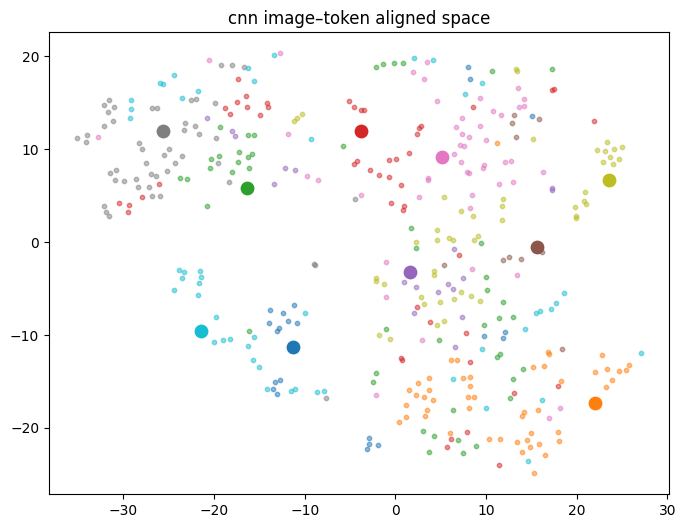


[resnet50] t-SNE visualization
Loaded 12575 images from /users/PAS2985/tingle9/dataset/footprint_patches/train, 117 classes.
Loaded 3831 images from /users/PAS2985/tingle9/dataset/footprint_patches/test, 117 classes.
loaded [resnet50] contrastive encoder.
[resnet50] encoding TRAIN/TEST features...
loaded [resnet50] alignment heads
t-SNE subset classes (index): [5, 33, 49, 51, 53, 62, 65, 97, 108, 113]
t-SNE subset class names   : ['species_005', 'species_033', 'species_049', 'species_051', 'species_053', 'species_062', 'species_065', 'species_097', 'species_108', 'species_113']


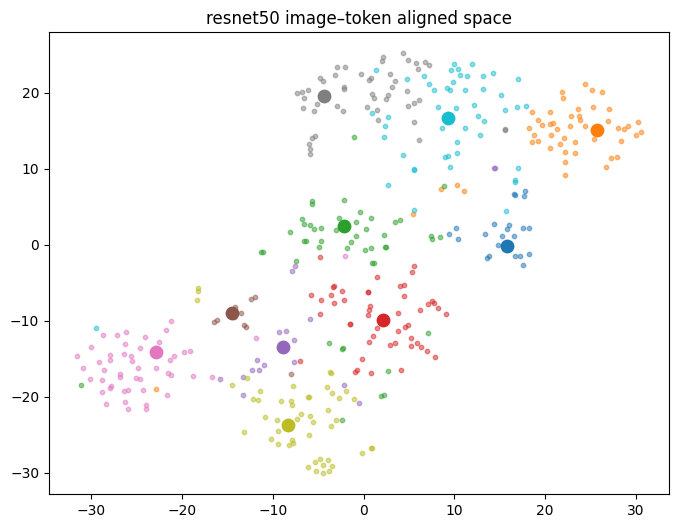


[vgg16] t-SNE visualization
Loaded 12575 images from /users/PAS2985/tingle9/dataset/footprint_patches/train, 117 classes.
Loaded 3831 images from /users/PAS2985/tingle9/dataset/footprint_patches/test, 117 classes.
loaded [vgg16] contrastive encoder.
[vgg16] encoding TRAIN/TEST features...
loaded [vgg16] alignment heads
t-SNE subset classes (index): [5, 33, 49, 51, 53, 62, 65, 97, 108, 113]
t-SNE subset class names   : ['species_005', 'species_033', 'species_049', 'species_051', 'species_053', 'species_062', 'species_065', 'species_097', 'species_108', 'species_113']


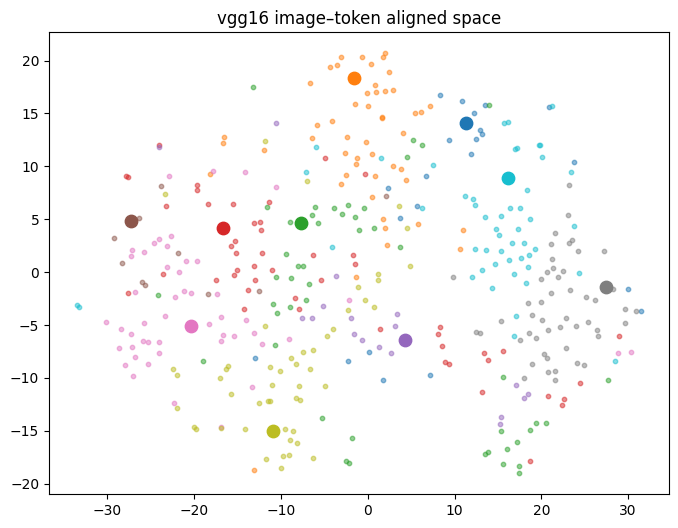


[vit_b_16] t-SNE visualization
Loaded 12575 images from /users/PAS2985/tingle9/dataset/footprint_patches/train, 117 classes.
Loaded 3831 images from /users/PAS2985/tingle9/dataset/footprint_patches/test, 117 classes.
loaded [vit_b_16] contrastive encoder.
[vit_b_16] encoding TRAIN/TEST features...
loaded [vit_b_16] alignment heads
t-SNE subset classes (index): [5, 33, 49, 51, 53, 62, 65, 97, 108, 113]
t-SNE subset class names   : ['species_005', 'species_033', 'species_049', 'species_051', 'species_053', 'species_062', 'species_065', 'species_097', 'species_108', 'species_113']


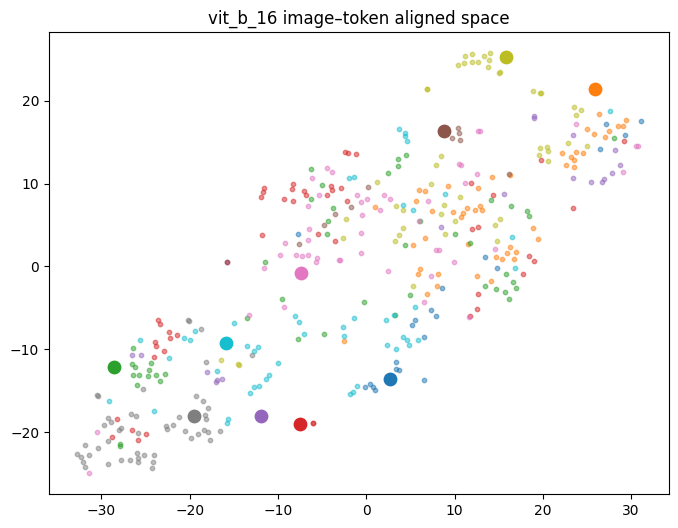

In [54]:
def main():
    torch.set_grad_enabled(False)

    backbones = ["cnn", "resnet50", "vgg16", "vit_b_16"]
    batch_size = 64
    num_workers = 8

    print("Device:", DEVICE)

    for backbone in backbones:
        print("\n" + "=" * 80)
        print(f"[{backbone}] t-SNE visualization")
        print("=" * 80)

        # 1) loader / dataset
        train_ds, test_ds, train_loader, test_loader, num_classes = build_loaders(
            backbone, batch_size=batch_size, num_workers=num_workers
        )

        # 2) contrastive encoder load + embedding
        encoder = load_contrastive_encoder_for_eval(backbone, DEVICE)

        print(f"[{backbone}] encoding TRAIN/TEST features...")

        # 3) Encoder + alignments heads load
        img_proj, txt_enc = load_alignment_heads(
            backbone,
            num_classes=num_classes,
            encoder_out_dim=encoder.out_dim,
            device=DEVICE,
        )

        all_cls = list(range(num_classes))
        random.seed(0)
        num_subset = min(10, num_classes)
        subset_classes = sorted(random.sample(all_cls, num_subset))
        print("t-SNE subset classes (index):", subset_classes)
        print("t-SNE subset class names   :", [train_ds.idx_to_class[c] for c in subset_classes])
        
        image_z, image_labels = collect_projected_image_embeddings(
            encoder, img_proj, train_loader, DEVICE,
            class_subset=subset_classes,
            max_per_class=50,
        )
        
        text_z, text_labels = collect_text_embeddings(
            txt_enc, subset_classes, DEVICE
        )
        
        title = f"{backbone} image–token aligned space"
        
        plot_tsne(
            image_z, image_labels,
            text_z, text_labels,
            idx_to_class=train_ds.idx_to_class,
            title=title,
        )
        
main()